# Solving Lunar Lander problem
---
Solve OpenAI Gym's LunarLander-v2 environment using all of the following techniques:

1. Q-learning with neural networks (deep Q-learning)

2. Double deep Q-learning to avoid over-estimating the Q-values

3. Experience replay, to break the strong temporal correlation of serial experiences, create a more i.i.d. sampling, which is an assumption of gradient based algorithms, and for potentially saving and retrieving later on rare, but useful, experiences.

4. Dueling networs, where you break up the q-value as a sum of state value and an advantge value (Q = V + A), to increase the robustness of the learning algorithm

In addition, a simple grid search was implemented in Python to explore various combinations of hyper-parameters

### Import the Necessary Packages

In [1]:
%reset -f

In [2]:
import gym
!pip install box2d
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import pandas as pd
import json

import time

from rlgtsrc.project2 import rl_analytics
from tqdm.notebook import tqdm
from rlgtsrc.project2 import utils
import os

You should consider upgrading via the 'c:\users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
def plotRewardsPerEpisode(rewards_per_episode, ax, title, rolling_window = None, addSessionMean = False,
                          title_size = 16, legend_size = 16, axis_size = 16):

    
    ax.plot(rewards_per_episode, alpha = 0.7)
    # Add rolling window average and stdev
    
    if rolling_window is not None:
        rolling_average = pd.Series(rewards_per_episode).rolling(window = rolling_window).mean()
        rolling_std = pd.Series(rewards_per_episode).rolling(window=rolling_window).std()
        ax.plot(rolling_average, color = 'red', alpha = 0.9, label = r"$R_{rolling mean}$"+"={:2.1f}".format(rolling_average.iloc[-1]) + r", $\sigma_{rolling}$ = " + "{:2.1f}".format(rolling_std.iloc[-1]))

    ax.set_xlabel("Episode", size=axis_size)
    ax.set_ylabel("Total reward per episode", size=axis_size)
    
    if addSessionMean:
        mean_reward = np.mean(rewards_per_episode)
        std_reward = np.std(rewards_per_episode)
        
        ax.axhline(mean_reward, linestyle='--', color="black", label=r"$R_{mean}$"+"={:2.1f}, ".format(mean_reward) + r"$\sigma = $" + "{:2.1f}".format(std_reward))
        

    #ax.axhline(mean_reward, linestyle='--', color="black", label=r"$R_{mean}$" + "=  {:2.1f}, ".format(mean_reward) + r"$\sigma = $" + "{:2.1f}".format(std_reward))
    

    ax.legend(fontsize=legend_size)
    if title is None:
        ax.set_title("{} \n Reward across {:2.0f} episodes".format(configParams.dict["fig_title"],configParams.dict["nEpisodes"]),
                 size=title_size)
    
    ax.set_title(title, size=title_size)
    return ax
    

### Create the Environment and Agent

Initialize the environment in the code cell below.

In [4]:
env = gym.make('LunarLander-v2')

print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

RANDOM_SEED = 1234
# Reset the environment
env.seed(RANDOM_SEED)
env.action_space.seed(RANDOM_SEED)

State shape:  (8,)
Number of actions:  4


[1234]

In [5]:
device = torch.device("cpu")

### Best performing parameters

The best performing agent was using a constant constant power-style decay

Specify the location of the master_exp24.json file

In [6]:
root = "./experiments/local_runs_for_submission"
exp_file_name = "master_exp4.json"
templateParamsConfig = utils.ConfigParams(json_path = os.path.join(root, exp_file_name))
templateParamsConfig.dict

{'GridJobsCompletedFileName': 'master_grid.pkl',
 'NeuralNet': 'DuelingDeepQLearnerCustomizable',
 'RANDOM_SEED': 1234,
 'RLAgent': 'DoubleDeepQLearner',
 'activations': 'relu',
 'batchSize': 64,
 'epsilon_decay': 0.995,
 'epsilon_scheduler': 'constantScaleRampDownWithMin',
 'epsilon_start': 1.0,
 'fig_name': 'Lunar Lander.jpg',
 'fig_title': 'Lunar Lander',
 'gamma': 0.99,
 'greedy_scheme': 'greedy',
 'jobs_filename': 'grid_jobs_lunar_lander.txt',
 'minEpisodesFullExploration': 50,
 'minNumEpisodesBeforeJumpToZero': 9900,
 'min_epsilon': 0.01,
 'nEpisodes': 1000,
 'nEpisodesTestRun': 120,
 'neuralNetDimensions': [128, 64, 32],
 'neural_net_update_weight': 0.01,
 'neural_network_loss_func': 'MSE',
 'numEpisodesToEndEpsilonRampDown': 280,
 'pytorch_optim_learning_rate': 0.001,
 'replay_size': 100000,
 'rolling_window': 0.05,
 'root': 'E:/PycharmProjects/RL-GT-Spring2021/rlgtsrc/project2/experiments/lunar_lander/local_runs_for_submission/',
 'samplingMethod': 'random',
 'saveResultInterv

In [7]:
# Update the hard-coded root variable in the config file, which is used to save plots and neural network parameters
templateParamsConfig.dict['root'] = "./experiments/local_runs_for_submission"

### Create the Environment and Agent

Initialize the environment in the code cell below.

In [8]:
env = gym.make('LunarLander-v2')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print('State shape: ', state_dim)
print('Number of actions: ', action_dim)

State shape:  8
Number of actions:  4


### Set the seed of the agent

To ensure reproducibilit yof best hyperparameters found, set the seed

In [9]:
# Reset the environment
env.seed(templateParamsConfig.dict["RANDOM_SEED"])
env.action_space.seed(templateParamsConfig.dict["RANDOM_SEED"])

[1234]

### Set the device - my local PC does not have a GPU

In [10]:
device = torch.device("cpu")

### Define an Epsilon Scheduler that will determine what the value of epsilon is per episode

In [11]:
epsilonScheduler = rl_analytics.EpsilonScheduler(dict(templateParamsConfig.dict))

### Run the agent

### Create the agent

In [12]:
agent_scale_ramp_down = rl_analytics.DoubleDQNAgent(state_dim=state_dim, action_dim=action_dim, params=templateParamsConfig, 
                                    device = device, experimentName = " master")

### Set the seed of the agent

In [13]:
agent_scale_ramp_down.setSeeds(seed = templateParamsConfig.dict["RANDOM_SEED"], device=device)

### Run the agent

In [14]:
env_solved_scale_ramp_down, made_progress_scale_ramp_down, training_rewards_scale_ramp_down, test_run_rewards_scale_ramp_down = agent_scale_ramp_down.runEpisodes(env, epsilonScheduler)

Episode 0	Average Reward: -91.61	Running time: 0.06	Internal time: 0.04	Gradient Descend call: 2.00
Episode 20	Average Reward: -161.81	Running time: 4.28	Internal time: 0.17	Gradient Descend call: 446.00
Episode 40	Average Reward: -179.18	Running time: 8.87	Internal time: 0.21	Gradient Descend call: 957.00
Episode 60	Average Reward: -179.95	Running time: 14.20	Internal time: 0.26	Gradient Descend call: 1517.00
Episode 80	Average Reward: -160.12	Running time: 19.71	Internal time: 0.30	Gradient Descend call: 2093.00
Episode 100	Average Reward: -143.30	Running time: 29.63	Internal time: 0.26	Gradient Descend call: 2824.00
Episode 120	Average Reward: -125.37	Running time: 50.28	Internal time: 0.61	Gradient Descend call: 4013.00
Episode 140	Average Reward: -93.31	Running time: 57.35	Internal time: 0.40	Gradient Descend call: 4677.00
Episode 160	Average Reward: -75.36	Running time: 79.32	Internal time: 0.28	Gradient Descend call: 6398.00
Episode 180	Average Reward: -63.62	Running time: 114.2

Episode 0	Average Reward: 204.53	Running time: 0.59	Internal time: 0.57	Gradient Descend call: 43293.00

Environment solved in 0 episodes!	Average Reward: 204.53	Total time: 0.59
Episode 1	Average Reward: 206.35
Environment solved in 1 episodes!	Average Reward: 206.35	Total time: 1.25
Episode 2	Average Reward: 229.92
Environment solved in 2 episodes!	Average Reward: 229.92	Total time: 1.72
Episode 3	Average Reward: 228.15
Environment solved in 3 episodes!	Average Reward: 228.15	Total time: 2.25
Episode 4	Average Reward: 235.39
Environment solved in 4 episodes!	Average Reward: 235.39	Total time: 2.56
Episode 5	Average Reward: 238.99
Environment solved in 5 episodes!	Average Reward: 238.99	Total time: 3.02
Episode 6	Average Reward: 239.05
Environment solved in 6 episodes!	Average Reward: 239.05	Total time: 3.83
Episode 7	Average Reward: 237.21
Environment solved in 7 episodes!	Average Reward: 237.21	Total time: 4.32
Episode 8	Average Reward: 237.06
Environment solved in 8 episodes!	Avera

Episode 73	Average Reward: 232.68
Environment solved in 73 episodes!	Average Reward: 232.68	Total time: 43.51
Episode 74	Average Reward: 232.93
Environment solved in 74 episodes!	Average Reward: 232.93	Total time: 44.09
Episode 75	Average Reward: 233.07
Environment solved in 75 episodes!	Average Reward: 233.07	Total time: 44.62
Episode 76	Average Reward: 233.54
Environment solved in 76 episodes!	Average Reward: 233.54	Total time: 45.05
Episode 77	Average Reward: 234.34
Environment solved in 77 episodes!	Average Reward: 234.34	Total time: 45.39
Episode 78	Average Reward: 234.24
Environment solved in 78 episodes!	Average Reward: 234.24	Total time: 45.80
Episode 79	Average Reward: 233.92
Environment solved in 79 episodes!	Average Reward: 233.92	Total time: 46.33
Episode 80	Average Reward: 233.65	Running time: 46.87	Internal time: 0.53	Gradient Descend call: 43293.00

Environment solved in 80 episodes!	Average Reward: 233.65	Total time: 46.87
Episode 81	Average Reward: 234.22
Environment s

### Plot the data that was produced by this run

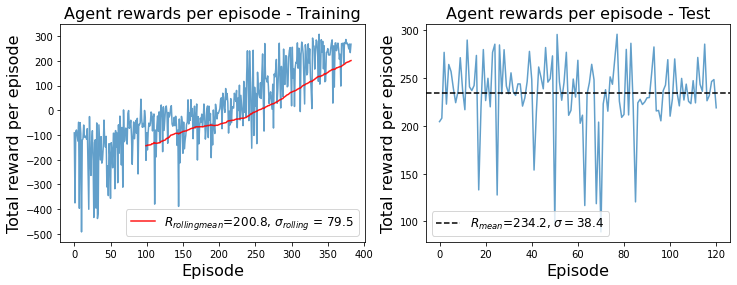

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
ax = plotRewardsPerEpisode(training_rewards_scale_ramp_down, axs[0], title = "Agent rewards per episode - Training", rolling_window=100,
                          title_size = 16, legend_size = 12, axis_size = 16)
ax = plotRewardsPerEpisode(test_run_rewards_scale_ramp_down, axs[1], title = "Agent rewards per episode - Test",addSessionMean = True,
                          title_size = 16, legend_size = 12, axis_size = 16)


In [16]:
print(" The envionment was solved after {} episodes".format(len(training_rewards_scale_ramp_down)))

 The envionment was solved after 383 episodes


### Visualize the Q-values from the training network

Insert various value for the state space, and plot the state value, obtained as max_a Qmm

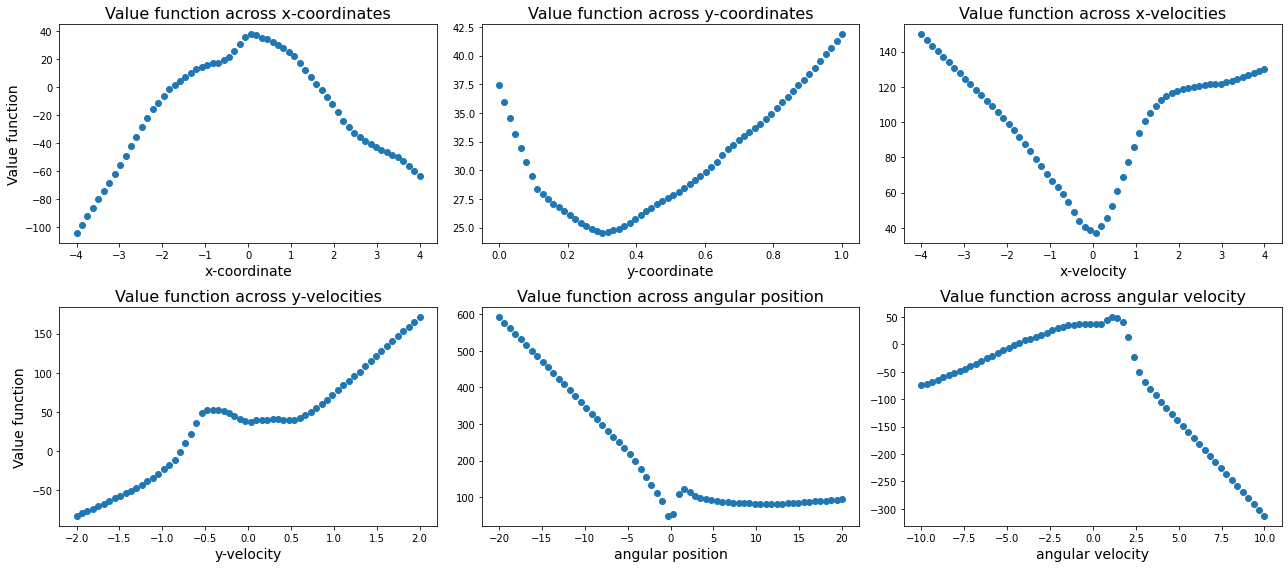

In [17]:
batch_size = 64
fig = plt.figure(figsize = (18, 8))
ax = fig.add_subplot(2, 3, 1)

title_size = 16
label_size = 14

slight_y_increase = 0.01

# Q-values over x axis
maxrange = 4
xs = np.linspace(-maxrange, maxrange, batch_size)
obs_x = [[x, slight_y_increase,0,0,0,0,0,0] for x in xs]
obs_x = np.array(obs_x).reshape( batch_size, 8)

state_vals, _ = agent_scale_ramp_down.trainingModel(torch.Tensor(obs_x)).max(dim = 1)
ax.scatter(xs, state_vals.detach().numpy())
ax.set_title("Value function across x-coordinates", size = title_size)

ax.set_ylabel("Value function", size = label_size)
ax.set_xlabel("x-coordinate", size = label_size)

# Q-values over y-axis
maxrange = 1.0
ys = np.linspace(0.0, maxrange, batch_size)
obs_y = [[0, slight_y_increase + y, 0, 0, 0, 0, 0, 0] for y in ys]
obs_y = np.array(obs_y).reshape(batch_size, 8)

ax = fig.add_subplot(2, 3, 2)
state_vals, _ = agent_scale_ramp_down.trainingModel(torch.Tensor(obs_y)).max(dim = 1)
ax.scatter(ys, state_vals.detach().numpy())
ax.set_title("Value function across y-coordinates", size = title_size)
ax.set_xlabel("y-coordinate", size = label_size)

# Q-values over x-velocity
maxrange = 4.0
x_vel = np.linspace(-maxrange, maxrange, batch_size)
x_vel_s = [[0, slight_y_increase,x, 0, 0, 0, 0, 0] for x in x_vel]
x_vel_s = np.array(x_vel_s).reshape( batch_size, 8)

ax = fig.add_subplot(2, 3, 3)
state_vals, _ = agent_scale_ramp_down.trainingModel(torch.Tensor(x_vel_s)).max(dim = 1)
ax.scatter(x_vel, state_vals.detach().numpy())
ax.set_title("Value function across x-velocities", size = title_size)
ax.set_xlabel("x-velocity", size = label_size)


# Q-values over y-velocity
maxrange = 2.0
y_vel = np.linspace(-maxrange, maxrange, batch_size)
y_vel_s = [[0, slight_y_increase, 0, y, 0, 0, 0, 0] for y in y_vel]
y_vel_s = np.array(y_vel_s).reshape( batch_size, 8)

ax = fig.add_subplot(2, 3, 4)
state_vals, _ = agent_scale_ramp_down.trainingModel(torch.Tensor(y_vel_s)).max(dim = 1)
ax.scatter(y_vel, state_vals.detach().numpy())
ax.set_title("Value function across y-velocities", size = title_size)
ax.set_xlabel("y-velocity", size = label_size)
ax.set_ylabel("Value function", size = label_size)


# Q-values over angular position
maxrange = 20.0
angle_pos = np.linspace(-maxrange, maxrange, batch_size)
angle_pos_s = [[0, slight_y_increase, 0, 0, theta, 0, 0, 0] for theta in angle_pos]
angle_pos_s = np.array(angle_pos_s).reshape( batch_size, 8)

ax = fig.add_subplot(2, 3, 5)
state_vals, _ = agent_scale_ramp_down.trainingModel(torch.Tensor(angle_pos_s)).max(dim = 1)
ax.scatter(angle_pos, state_vals.detach().numpy())
ax.set_title("Value function across angular position", size = title_size)
ax.set_xlabel("angular position", size = label_size)



# Q-values over angular velocity
maxrange = 10.0
angle_vel = np.linspace(-maxrange, maxrange, batch_size)
angle_vel_s = [[0, slight_y_increase, 0, 0, 0, theta_v, 0, 0] for theta_v in angle_vel]
angle_vel_s = np.array(angle_vel_s).reshape( batch_size, 8)

ax = fig.add_subplot(2, 3, 6)
state_vals, _ = agent_scale_ramp_down.trainingModel(torch.Tensor(angle_vel_s)).max(dim = 1)
ax.scatter(angle_vel, state_vals.detach().numpy())
ax.set_title("Value function across angular velocity", size = title_size)
ax.set_xlabel("angular velocity", size = label_size)

plt.tight_layout()

### Run a grid over the hyper-parameters

This takes a long time to run - I have create separate jupyter notebooks, one per hyperparameter, to run in Google Colab - However, the code belows gives an idea of the functionality, in case of running them in a PC

In [18]:
root = "./experiments/local_runs_for_submission/local_grid_run"
exp_file_name = "master_exp4.json"
templateParamsConfig = utils.ConfigParams(json_path = os.path.join(root, exp_file_name))
templateParamsConfig.dict

{'GridJobsCompletedFileName': 'master_grid.pkl',
 'NeuralNet': 'DuelingDeepQLearnerCustomizable',
 'RANDOM_SEED': 1234,
 'RLAgent': 'DoubleDeepQLearner',
 'activations': 'relu',
 'batchSize': 64,
 'epsilon_decay': 0.995,
 'epsilon_scheduler': 'constantScaleRampDownWithMin',
 'epsilon_start': 1.0,
 'fig_name': 'Lunar Lander.jpg',
 'fig_title': 'Lunar Lander',
 'gamma': 0.99,
 'greedy_scheme': 'greedy',
 'jobs_filename': 'grid_jobs_lunar_lander.txt',
 'minEpisodesFullExploration': 50,
 'minNumEpisodesBeforeJumpToZero': 9900,
 'min_epsilon': 0.01,
 'nEpisodes': 1000,
 'nEpisodesTestRun': 120,
 'neuralNetDimensions': [128, 64, 32],
 'neural_net_update_weight': 0.01,
 'neural_network_loss_func': 'MSE',
 'numEpisodesToEndEpsilonRampDown': 280,
 'pytorch_optim_learning_rate': 0.001,
 'replay_size': 100000,
 'rolling_window': 0.05,
 'root': 'E:/PycharmProjects/RL-GT-Spring2021/rlgtsrc/project2/experiments/lunar_lander/local_runs_for_submission/',
 'samplingMethod': 'random',
 'saveResultInterv

In [19]:
templateParamsConfig.dict['nEpisodes'] = 20
templateParamsConfig.dict['nEpisodesTestRun'] = 5

templateParamsConfig.dict['root'] = "./experiments/local_runs_for_submission/local_grid_run"

searchParamsDict = {
                      
    'trainEveryStep': [4, 10],
    "gamma": [0.99, 0.999, 0.9],
    'neuralNetDimensions': [[128, 32, 32]],
    "epsilon_scheduler": ["ramp_down_jump_zero", "constantScaleRampDownWithMin"],

    
}

In [20]:
grid_lunar_lander = rl_analytics.GridSearch(baseParams = templateParamsConfig, envName = "LunarLander-v2", searchParamsDict = searchParamsDict, 
                                         device = torch.device("cpu"))

In [21]:
grid_search_results_lunar_lander = grid_lunar_lander.runGrid()

Running . . .  Exp 1  - job 1/12


Episode 0	Average Reward: -91.61	Running time: 0.06	Internal time: 0.04	Gradient Descend call: 2.00
Episode 20	Average Reward: -155.56	Running time: 5.62	Internal time: 0.18	Gradient Descend call: 472.00



Episode 0	Average Reward: -163.81	Running time: 0.35	Internal time: 0.33	Gradient Descend call: 472.00
Episode 5	Average Reward: -187.35
Remaining time for completion. . . 1.48 min
Saving 1 jobs done...
Running . . .  Exp 2  - job 2/12


Episode 0	Average Reward: -91.61	Running time: 0.07	Internal time: 0.04	Gradient Descend call: 2.00
Episode 20	Average Reward: -161.59	Running time: 5.55	Internal time: 0.25	Gradient Descend call: 485.00



Episode 0	Average Reward: -664.86	Running time: 0.13	Internal time: 0.10	Gradient Descend call: 485.00
Episode 5	Average Reward: -665.51
Remaining time for completion. . . 1.21 min
Saving 2 jobs done...
Running . . .  Exp 3  - job 3/12


Episode 0	Average Reward: -91.61	Running time: 0.05	Internal time: 0.03	Gradient Descend call: 1.00
Episode 20	Average Reward: -168.83	Running time: 3.48	Internal time: 0.08	Gradient Descend call: 188.00



Episode 0	Average Reward: -903.27	Running time: 0.14	Internal time: 0.12	Gradient Descend call: 188.00
Episode 5	Average Reward: -935.59
Remaining time for completion. . . 0.96 min
Saving 3 jobs done...
Running . . .  Exp 4  - job 4/12


Episode 0	Average Reward: -91.61	Running time: 0.05	Internal time: 0.03	Gradient Descend call: 1.00
Episode 20	Average Reward: -161.59	Running time: 3.55	Internal time: 0.15	Gradient Descend call: 191.00



Episode 0	Average Reward: -696.26	Running time: 0.14	Internal time: 0.12	Gradient Descend call: 191.00
Episode 5	Average Reward: -606.73
Remaining time for completion. . . 0.87 min
Saving 4 jobs done...
Running . . .  Exp 5  - job 5/12


Episode 0	Average Reward: -91.61	Running time: 0.05	Internal time: 0.03	Gradient Descend call: 1.00
Episode 20	Average Reward: -161.59	Running time: 3.54	Internal time: 0.12	Gradient Descend call: 191.00



Episode 0	Average Reward: -184.32	Running time: 1.71	Internal time: 1.69	Gradient Descend call: 191.00
Episode 5	Average Reward: -522.77
Remaining time for completion. . . 0.81 min
Saving 5 jobs done...
Running . . .  Exp 6  - job 6/12


Episode 0	Average Reward: -91.61	Running time: 0.05	Internal time: 0.03	Gradient Descend call: 1.00
Episode 20	Average Reward: -187.27	Running time: 3.54	Internal time: 0.09	Gradient Descend call: 174.00



Episode 0	Average Reward: -543.79	Running time: 0.13	Internal time: 0.11	Gradient Descend call: 174.00
Episode 5	Average Reward: -559.64
Remaining time for completion. . . 0.65 min
Saving 6 jobs done...
Running . . .  Exp 7  - job 7/12


Episode 0	Average Reward: -91.61	Running time: 0.06	Internal time: 0.04	Gradient Descend call: 2.00
Episode 20	Average Reward: -161.59	Running time: 5.48	Internal time: 0.27	Gradient Descend call: 485.00



Episode 0	Average Reward: -445.44	Running time: 0.14	Internal time: 0.12	Gradient Descend call: 485.00
Episode 5	Average Reward: -426.49
Remaining time for completion. . . 0.54 min
Saving 7 jobs done...
Running . . .  Exp 8  - job 8/12


Episode 0	Average Reward: -91.61	Running time: 0.06	Internal time: 0.04	Gradient Descend call: 2.00
Episode 20	Average Reward: -161.59	Running time: 5.75	Internal time: 0.25	Gradient Descend call: 485.00



Episode 0	Average Reward: -695.14	Running time: 0.12	Internal time: 0.10	Gradient Descend call: 485.00
Episode 5	Average Reward: -692.66
Remaining time for completion. . . 0.43 min
Saving 8 jobs done...
Running . . .  Exp 9  - job 9/12


Episode 0	Average Reward: -91.61	Running time: 0.06	Internal time: 0.04	Gradient Descend call: 2.00
Episode 20	Average Reward: -176.35	Running time: 5.22	Internal time: 0.14	Gradient Descend call: 451.00



Episode 0	Average Reward: -519.02	Running time: 0.30	Internal time: 0.27	Gradient Descend call: 451.00
Episode 5	Average Reward: -375.38
Remaining time for completion. . . 0.33 min
Saving 9 jobs done...
Running . . .  Exp 10  - job 10/12


Episode 0	Average Reward: -91.61	Running time: 0.07	Internal time: 0.04	Gradient Descend call: 2.00
Episode 20	Average Reward: -155.56	Running time: 5.38	Internal time: 0.18	Gradient Descend call: 472.00



Episode 0	Average Reward: -164.87	Running time: 0.35	Internal time: 0.33	Gradient Descend call: 472.00
Episode 5	Average Reward: -246.13
Remaining time for completion. . . 0.23 min
Saving 10 jobs done...
Running . . .  Exp 11  - job 11/12


Episode 0	Average Reward: -91.61	Running time: 0.05	Internal time: 0.03	Gradient Descend call: 1.00
Episode 20	Average Reward: -187.27	Running time: 3.32	Internal time: 0.10	Gradient Descend call: 174.00



Episode 0	Average Reward: -542.63	Running time: 0.13	Internal time: 0.11	Gradient Descend call: 174.00
Episode 5	Average Reward: -845.28
Remaining time for completion. . . 0.11 min
Saving 11 jobs done...
Running . . .  Exp 12  - job 12/12


Episode 0	Average Reward: -91.61	Running time: 0.05	Internal time: 0.03	Gradient Descend call: 1.00
Episode 20	Average Reward: -161.59	Running time: 3.51	Internal time: 0.12	Gradient Descend call: 191.00



Episode 0	Average Reward: -666.18	Running time: 0.14	Internal time: 0.12	Gradient Descend call: 191.00
Episode 5	Average Reward: -602.02
Remaining time for completion. . . 0.00 min
Saving 12 jobs done...


## Example of how to load neural network parameters, as computed in Google Colab sessions

### Load one model parameter

In [22]:
exp_to_load = {'GridJobsCompletedFileName': 'master_grid.pkl',
           'NeuralNet': 'DuelingDeepQLearnerCustomizable',
           'RANDOM_SEED': 1234,
           'RLAgent': 'DoubleDeepQLearner',
           'activations': 'relu',
           'batchSize': 64,
           'epsilon_decay': 0.995,
           'epsilon_scheduler': 'constantScaleRampDownWithMin',
           'epsilon_start': 1.0,
           'fig_name': 'Lunar Lander.jpg',
           'fig_title': 'Lunar Lander',
           'gamma': 0.99,
           'greedy_scheme': 'greedy',
           'jobs_filename': 'grid_jobs_lunar_lander.txt',
           'minEpisodesFullExploration': 50,
           'minNumEpisodesBeforeJumpToZero': 9900,
           'min_epsilon': 0.01,
           'nEpisodes': 1000,
           'nEpisodesTestRun': 120,
           'neuralNetDimensions': [128, 64, 32],
           'neural_net_update_weight': 0.01,
           'neural_network_loss_func': 'MSE',
           'numEpisodesToEndEpsilonRampDown': 280,
           'pytorch_optim_learning_rate': 0.001,
           'replay_size': 100000,
           'rolling_window': 0.05,
           'root': "./experiments/Google_Colab_grids/Grid_1_Exp_4_posta",
           'samplingMethod': 'random',
           'saveResultIntervals': [0.02,
                                   0.2,
                                   0.3,
                                   0.4,
                                   0.5,
                                   0.6,
                                   0.7,
                                   0.8,
                                   0.9,
                                   0.99],
           'trainEveryStep': 4}

In [23]:
templateParamsConfig = utils.ConfigParams(json_path = None, jsondata = exp_to_load)
simpleParamDict = dict(templateParamsConfig.dict)
epsilonScheduler = rl_analytics.EpsilonScheduler(simpleParamDict)
agent = rl_analytics.DoubleDQNAgent(state_dim=8, action_dim=4, params=templateParamsConfig, experimentName = " master", device = device)

In [24]:
google_colab_root = "./experiments/Google_Colab_grids/Grid_1_Exp_4_posta"
exp_name          = "Exp 4"
net_params = utils.load_checkpoint(path = google_colab_root, filename = exp_name, 
                      model = agent.trainingModel, 
                      optimizer = agent.optimizer
                     )



In [25]:
env_test = gym.make('LunarLander-v2')
RANDOM_SEED = 1234
# Reset the environment
env_test.seed(RANDOM_SEED)
env_test.action_space.seed(RANDOM_SEED)

agent.runTestEpisodes(env_test=env_test, model=agent.trainingModel)

Episode 0	Average Reward: 114.02	Running time: 1.61	Internal time: 1.59	Gradient Descend call: 0.00
Episode 3	Average Reward: 215.22
Environment solved in 3 episodes!	Average Reward: 215.22	Total time: 3.05
Episode 4	Average Reward: 223.76
Environment solved in 4 episodes!	Average Reward: 223.76	Total time: 3.42
Episode 5	Average Reward: 227.37
Environment solved in 5 episodes!	Average Reward: 227.37	Total time: 4.11
Episode 6	Average Reward: 226.99
Environment solved in 6 episodes!	Average Reward: 226.99	Total time: 4.81
Episode 7	Average Reward: 224.86
Environment solved in 7 episodes!	Average Reward: 224.86	Total time: 5.17
Episode 8	Average Reward: 227.73
Environment solved in 8 episodes!	Average Reward: 227.73	Total time: 5.53
Episode 9	Average Reward: 230.93
Environment solved in 9 episodes!	Average Reward: 230.93	Total time: 5.95
Episode 10	Average Reward: 234.62
Environment solved in 10 episodes!	Average Reward: 234.62	Total time: 6.34
Episode 11	Average Reward: 235.65
Environm

Episode 75	Average Reward: 239.08
Environment solved in 75 episodes!	Average Reward: 239.08	Total time: 39.90
Episode 76	Average Reward: 239.16
Environment solved in 76 episodes!	Average Reward: 239.16	Total time: 40.35
Episode 77	Average Reward: 239.16
Environment solved in 77 episodes!	Average Reward: 239.16	Total time: 40.93
Episode 78	Average Reward: 237.09
Environment solved in 78 episodes!	Average Reward: 237.09	Total time: 42.24
Episode 79	Average Reward: 237.22
Environment solved in 79 episodes!	Average Reward: 237.22	Total time: 42.64
Episode 80	Average Reward: 237.32	Running time: 43.13	Internal time: 0.48	Gradient Descend call: 0.00

Environment solved in 80 episodes!	Average Reward: 237.32	Total time: 43.13
Episode 81	Average Reward: 237.56
Environment solved in 81 episodes!	Average Reward: 237.56	Total time: 43.65
Episode 82	Average Reward: 237.73
Environment solved in 82 episodes!	Average Reward: 237.73	Total time: 44.09
Episode 83	Average Reward: 237.67
Environment solve

(False,
 True,
 [114.02252061178783,
  256.16567286457564,
  225.58652913906076,
  265.105021885383,
  257.9283735928576,
  245.38266162973434,
  224.71017993899505,
  209.99696335960925,
  250.64797031382312,
  259.74719271348255,
  271.48371628190523,
  247.01090263752306,
  244.3466947041188,
  254.84923021794938,
  282.92537586257754,
  266.6472400184663,
  258.30095498935583,
  249.5745694303016,
  234.50480629324122,
  269.623935495507,
  261.91739722622555,
  244.09200645629335,
  259.0430223115425,
  283.00119674285963,
  227.04507877296953,
  260.5715236627593,
  258.59430391151216,
  258.2966330519057,
  248.40948131421877,
  243.6798857332047,
  256.3951749039111,
  258.8515741212201,
  240.24791596067598,
  224.5562538710969,
  220.25185498936912,
  239.98208979958167,
  254.8883952035152,
  252.2676760960799,
  222.51139049597805,
  240.23945460708867,
  255.95880181528165,
  209.7443888563751,
  264.49248653883,
  244.56485589146433,
  283.37614721109657,
  256.8426382299

## Google colab runs to investigate the effect of various hyperparameter choices

To come up with more robust measures of hyperparameter effect and because GPU runs across multiple different Google Colab sessions were not reproducible, we ran 20 times 500 epidoes for a given hyperparameter, over various seeds for the ranom number geenrator, pytorck and gym, and then average across the 20 rewards, for a given episode. 

**Note**: Please update the absolute path to the location of the Google Colab result pickle files, with extension "pkl"

In [26]:
def plotCrossSectionalMeanRewards(data, experiments, label_tag, param_name, title, title_size = 16, legend_size = 16, axis_size = 16,
                                 moving_window = None, ax = None, show_ylabel = True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (12, 10))
    for exp in experiments:
        mean_cross_sectional_rewards = pd.DataFrame(data[exp]["training rewards"]).mean(axis = 0)        
        if moving_window:            
            mean_cross_sectional_rewards_rolling = mean_cross_sectional_rewards.rolling(window = moving_window).mean().dropna()            
            label = label_tag.format(param_val = data[exp]["config"].dict[param_name])        
            mean_cross_sectional_rewards_rolling.plot(ax = ax, label = label)
            mean_cross_sectional_rewards.plot(ax = ax, color = "black", alpha = 0.1, label = "")
            
        else:
            mean_cross_sectional_rewards.plot(ax = ax, label = label)
    ax.legend(fontsize = legend_size)
    ax.set_title(title, size = title_size)
    if show_ylabel:        
        ax.set_ylabel("Mean reward per episode\nacross 20 different runs", size=axis_size)
    ax.set_xlabel("Episode", size=axis_size)

### Gather all the rewards across hyperparameters here

In [27]:
hyperparameters_runs = {}

### Neural Net Dimensions

In [28]:
root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/neuralNetDimensions"
filename = r"master_grid.pkl"

In [29]:
data = pickle.load(open(os.path.join(root, filename), "rb"))

In [30]:
experiments = ["Exp 1", "Exp 2", "Exp 3"]
label_tag = "Neural Net layers = {param_val}"
param_name = "neuralNetDimensions"
title = "Neural Network dimension"

hyperparameters_runs["neural_net_size"] = {"data": data,
                                          "experiments" : experiments,
                                          "label_tag": label_tag,
                                          "param_name": param_name,
                                          "title": title}

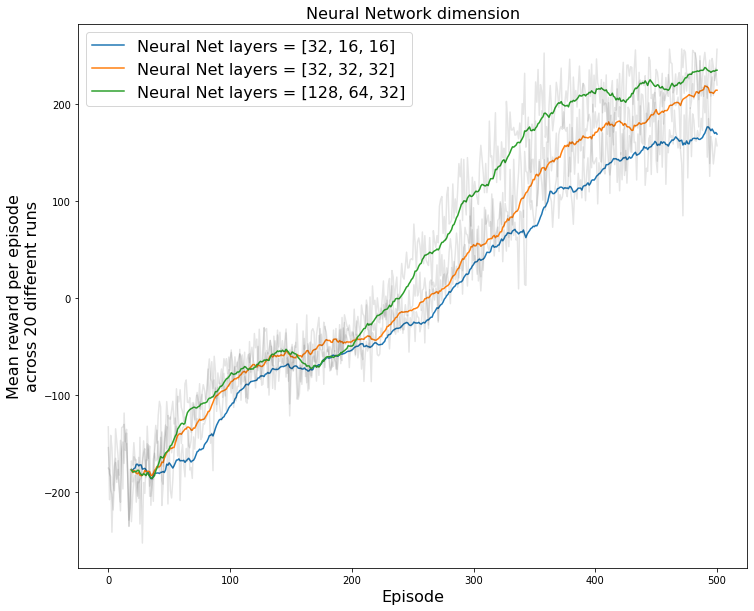

In [31]:
plotCrossSectionalMeanRewards(data, experiments, label_tag,param_name , title, moving_window = 20)

### Gamma

In [32]:
root = root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/gamma"
filename = r"master_grid.pkl"

In [33]:
data = pickle.load(open(os.path.join(root, filename), "rb"))

In [34]:
data.keys()

dict_keys(['Exp 1', 'Exp 2', 'Exp 3'])

In [80]:
### Add the data from a second run that I did
root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/gamma/second_run/gamma"
filename = r"master_grid.pkl"
gamma_extra_run = pickle.load(open(os.path.join(root, filename), "rb"))


In [36]:
data['Exp 4'] = gamma_extra_run['Exp 1']


In [37]:
experiments = ["Exp 1", "Exp 2", "Exp 3", "Exp 4"]
label_tag = r"$\gamma$ = {param_val:.2f}"
param_name = "gamma"
title = r"Decay rate $\gamma$"

hyperparameters_runs["gamma"] = {"data": data,
                              "experiments" : experiments,
                              "label_tag": label_tag,
                              "param_name": param_name,
                                "title": title}


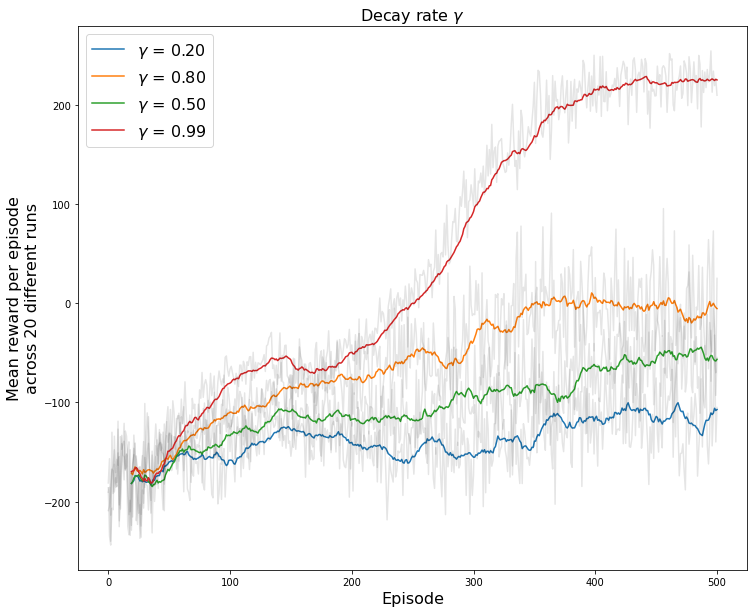

In [38]:
plotCrossSectionalMeanRewards(data, experiments, label_tag,param_name , title, moving_window = 20)

### Epsilon decay rate

In [39]:
root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/epsilon_decay"
filename = r"master_grid.pkl"

In [40]:
data = pickle.load(open(os.path.join(root, filename), "rb"))


In [41]:
data.keys()

dict_keys(['Exp 1', 'Exp 2'])

In [81]:
### Add the data from a second run that I did
root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/epsilon_decay/second_run/epsilon_decay"
filename = r"master_grid.pkl"
epsilon_decay_extra_run = pickle.load(open(os.path.join(root, filename), "rb"))

In [82]:
epsilon_decay_extra_run.keys()

dict_keys(['Exp 1', 'Exp 2'])

In [44]:
data['Exp 3'] = epsilon_decay_extra_run['Exp 1']
data['Exp 4'] = epsilon_decay_extra_run['Exp 2']


In [45]:
experiments = [ "Exp 3", "Exp 2",  "Exp 1",  "Exp 4"]
label_tag = r"$\delta_\epsilon$ = {param_val}"
param_name = "epsilon_decay"
title = "Epsilon Decay rate"

hyperparameters_runs["epsilon_decay"] = {"data": data,
                              "experiments" : experiments,
                              "label_tag": label_tag,
                              "param_name": param_name,
                                        "title": title}

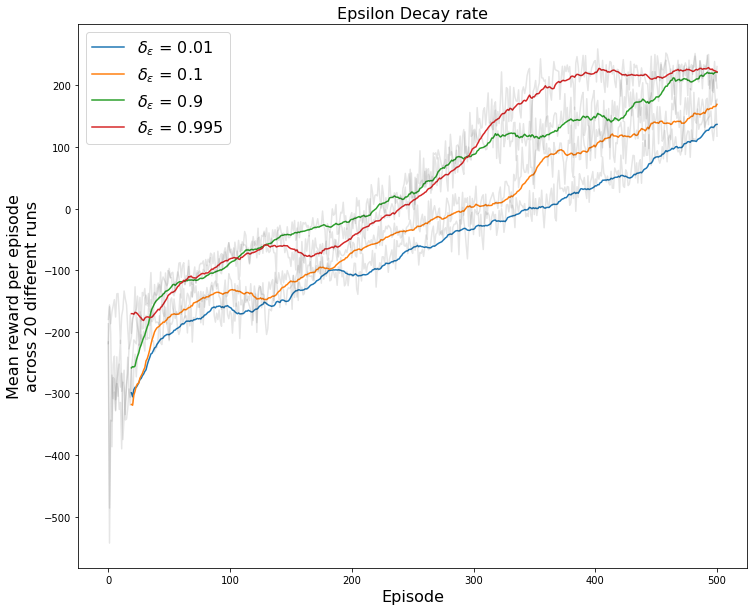

In [46]:
plotCrossSectionalMeanRewards(data, experiments, label_tag, param_name , title, moving_window=20)

### alpha - Stochastic Gradient descend step size

In [74]:
root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/alpha"
filename = r"master_grid.pkl"

In [75]:
data = pickle.load(open(os.path.join(root, filename), "rb"))

In [76]:
data.keys()

dict_keys(['Exp 1', 'Exp 2', 'Exp 3'])

In [78]:
### Add the data from a second run that I did
root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/alpha/second_run"
filename = r"master_grid.pkl"
alpha_extra_run = pickle.load(open(os.path.join(root, filename), "rb"))

In [79]:
alpha_extra_run.keys()

dict_keys(['Exp 1'])

In [52]:
data['Exp 4'] = alpha_extra_run['Exp 1']


In [53]:
experiments = ["Exp 1", "Exp 2", "Exp 3"]
label_tag = r"$\alpha$ = {param_val}"
param_name = "pytorch_optim_learning_rate"

title = r"$\alpha$ - Step size for the gradient descent"
hyperparameters_runs["alpha"] = {"data": data,
                              "experiments" : experiments,
                              "label_tag": label_tag,
                              "param_name": param_name,
                                "title": title}

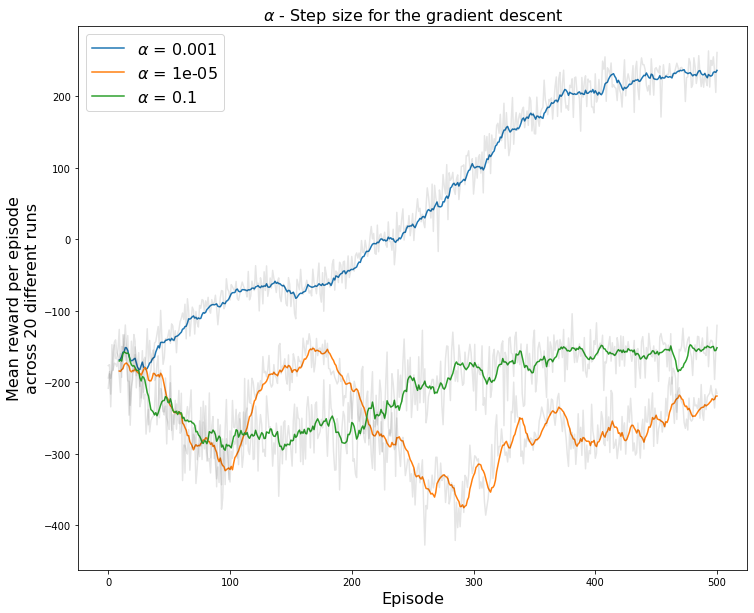

In [54]:

plotCrossSectionalMeanRewards(data, experiments, label_tag,param_name , title, moving_window=10)

### Buffer size

In [55]:
root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/buffer_size"
filename = r"master_grid.pkl"

In [56]:
data = pickle.load(open(os.path.join(root, filename), "rb"))


In [57]:
data.keys()

dict_keys(['Exp 1'])

In [58]:
data['Exp 1']['config'].dict["replay_size"]

1000

In [59]:
### Add the data from a second run that I did
root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/buffer_size/second_run/buffer_size"
filename = r"master_grid.pkl"
buffer_size_extra_run = pickle.load(open(os.path.join(root, filename), "rb"))
for exp in buffer_size_extra_run.keys():
    print(exp, " ", buffer_size_extra_run[exp]['config'].dict["replay_size"])

Exp 1   1000
Exp 2   10000
Exp 3   100


In [60]:
buffer_size_extra_run.keys()

dict_keys(['Exp 1', 'Exp 2', 'Exp 3'])

In [61]:
#data['Exp 2'] = buffer_size_extra_run["Exp 1"]
data['Exp 2'] = buffer_size_extra_run["Exp 2"]
data['Exp 3'] = buffer_size_extra_run["Exp 3"]

In [62]:
experiments = ["Exp 1", "Exp 2", "Exp 3"]
label_tag = "Buffer size = {param_val}"
param_name = "replay_size"

title = "Size of the replay buffer"

hyperparameters_runs["buffer_size"] = {"data": data,
                              "experiments" : experiments,
                              "label_tag": label_tag,
                              "param_name": param_name,
                                      "title": title}

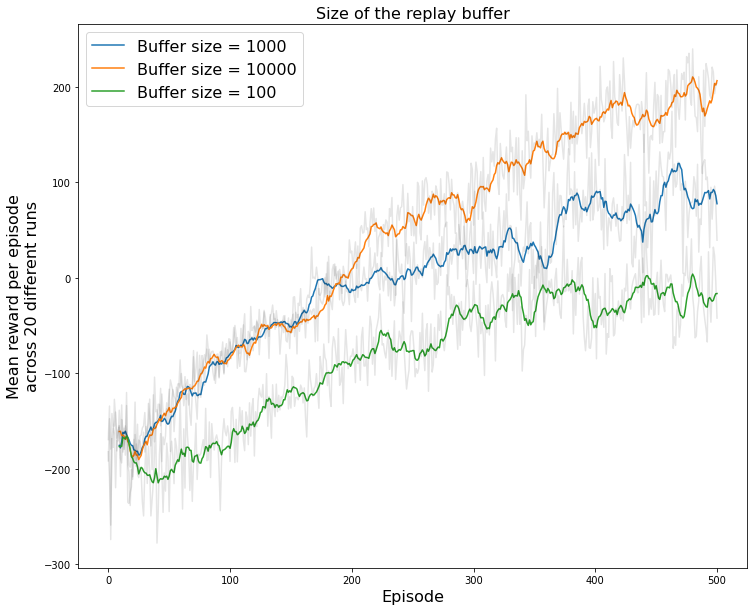

In [63]:
plotCrossSectionalMeanRewards(data, experiments, label_tag, param_name , title, moving_window=10)

### Frequency of training the network

In [64]:
root = "./experiments/Google_Colab_grids/Google_Colab_Grids_Multiple_Runs_Different_Seeds/trainEveryStep"
filename = r"master_grid.pkl"

In [65]:
data = pickle.load(open(os.path.join(root, filename), "rb"))


In [66]:
data.keys()

dict_keys(['Exp 1', 'Exp 2'])

In [67]:
data['Exp 1']['config'].dict["trainEveryStep"]

4

In [68]:
experiments = ["Exp 1", "Exp 2"]
label_tag = "Train network every = {param_val} steps"
param_name = "trainEveryStep"

title = "How frequently to perform a gradient descent step\n (in number of agent steps)"

hyperparameters_runs["trainEveryStep"] = {"data": data,
                              "experiments" : experiments,
                              "label_tag": label_tag,
                              "param_name": param_name,
                                      "title": title}

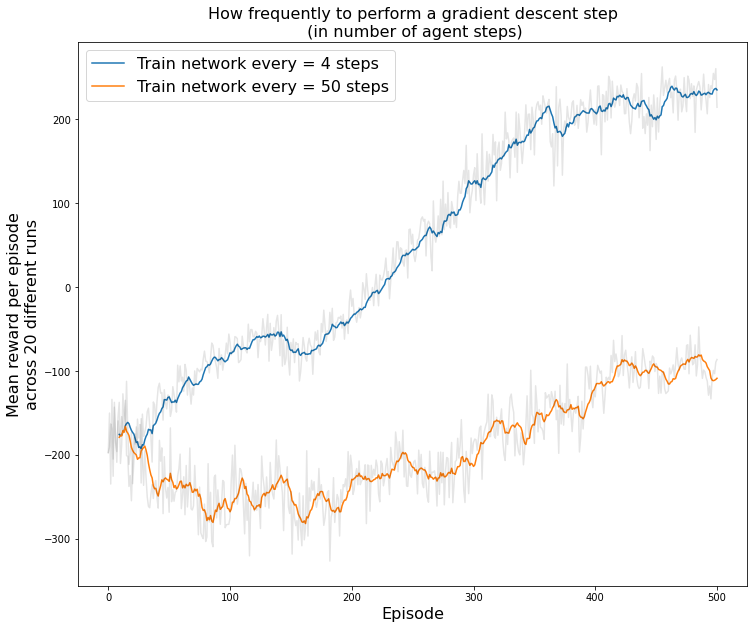

In [69]:
plotCrossSectionalMeanRewards(data, experiments, label_tag, param_name , title, moving_window=10)

### Put all these plots together

In [70]:
hyperparameters_runs.keys()

dict_keys(['neural_net_size', 'gamma', 'epsilon_decay', 'alpha', 'buffer_size', 'trainEveryStep'])

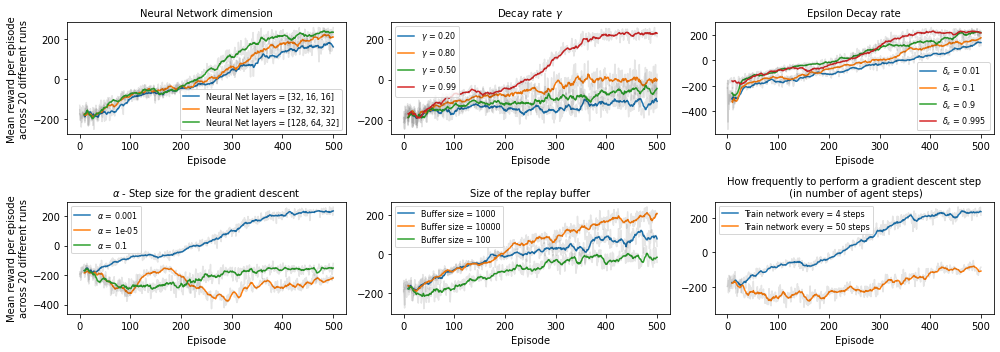

In [71]:
fig = plt.figure(figsize = (14, 5))
moving_window=10

for idx, param in enumerate(['neural_net_size', 'gamma', 'epsilon_decay', 'alpha', 'buffer_size', "trainEveryStep"]):
    
    ax = fig.add_subplot(2, 3, idx+1)
    
    
    show_ylabel = idx%3==0
    
    plotCrossSectionalMeanRewards(moving_window=moving_window, **hyperparameters_runs[param], ax = ax,
                                 title_size = 10, legend_size = 8, axis_size = 10, show_ylabel = show_ylabel)
    
    
plt.tight_layout()


In [72]:
np.log(0.5)/np.log(0.99)

68.96756393652842

In [73]:
np.log(0.5)/np.log(0.80)

3.1062837195053903